# Quickstart

Let's see how to make a sychrotron simulation quickly! All required files can be found in `example/` folder in the [repo](https://github.com/dkn16/Synax)

In [1]:
#%env XLA_PYTHON_CLIENT_PREALLOCATE=false
%env XLA_PYTHON_CLIENT_ALLOCATOR=platform


env: XLA_PYTHON_CLIENT_ALLOCATOR=platform


In [2]:
import os
import sys
import jax
jax.config.update("jax_enable_x64", True)
#sys.path.append('../synax/')

import synax,importlib
import jax.numpy as jnp
import interpax
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
import scipy.constants as const

In [3]:
#for debug
def reload_package(package):
    importlib.reload(package)
    for attribute_name in dir(package):
        attribute = getattr(package, attribute_name)
        if type(attribute) == type(package):
            importlib.reload(attribute)
            
reload_package(synax)

## Generating integration points
First thing to do is to generate the coordinates of all integration points. You can use ``synax.coords.get_healpix_positions()`` to quickly generate these coordinates for a healpix map.

`poss`: coordinates for integration points, e.g. `poss[0]` represents x coordinates.

`dls`: length of integration intervals.

`nhats`: unit vector of different line-of-sights (LoS).

You don't need to understand `dls` and `nhats` and just need to pass them to `synax.synax.Synax.sim()`.

In [4]:
nside = 64
num_int_points = 512

poss,dls,nhats = synax.coords.get_healpix_positions(nside=nside,num_int_points = num_int_points )

2024-09-15 10:28:26.609130: W external/xla/xla/service/gpu/nvptx_compiler.cc:765] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


Let's see the projection of 500-th integration points for every 10 LoS to the $x-y$ plane.

(3, 49152, 512)

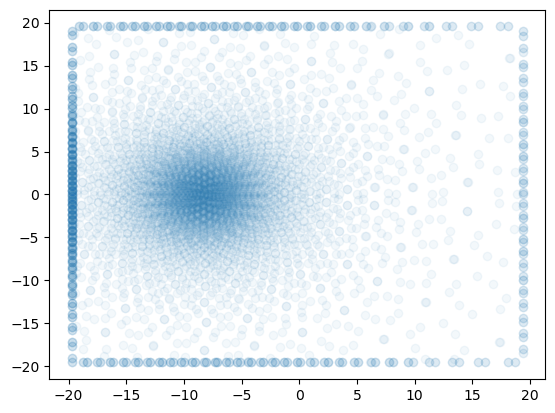

In [5]:
plt.scatter(poss[0,::10,500],poss[1,::10,500],alpha=0.05)
poss.shape

## Generating fields
Let's then generating different fields. First let's generate an analytical cosmic ray electron spectrum cosntant $C$ field: $$N(\gamma)d\gamma = C\gamma^{-p}d\gamma$$.
The model here is the WMAP model presented in [Page et al. 2007](https://iopscience.iop.org/article/10.1086/513699)

You can define a field generator `synax.cfield.C_WMAP()` first. It need the integration points coordinates `poss`. Then `C_generator.C_field()` takes model parameters and calculates the $C$ field at these points. 

In [6]:
C_generator = synax.cfield.C_WMAP(poss)

C_field = C_generator.C_field()

Let's generate the thermal electron density $n_e$ model with the intepolation on 3D grids.

First let's define the coordinates of the voxels in the 3D grid and read the 3D grids in.

In [7]:
nx,ny,nz = 256,256,64 # number of voxels along xyz axis

xs,step = jnp.linspace(-20,20,nx,endpoint=False,retstep=True)
xs = xs + step*0.5# get x coordinates

ys,step = jnp.linspace(-20,20,ny,endpoint=False,retstep=True)
ys = ys + step*0.5# get x coordinates

zs,step = jnp.linspace(-5,5,nz,endpoint=False,retstep=True)
zs = zs + step*0.5# get x coordinates

coords = jnp.meshgrid(xs,ys,zs,indexing='ij')
coords[0].shape

(256, 256, 64)

In [8]:
tereg = np.load('te.npy')

Let's visualize the grid $n_e$ field.

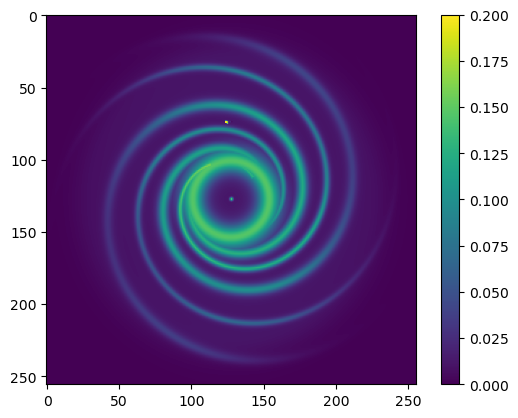

In [9]:
plt.imshow(tereg[:,:,32],vmax=0.2)
plt.colorbar()

Similarly, define a generator first. Now despite of the integration point coordinates, it also needs the coordinates of your 3D grid voxels.

In [10]:
TE_generator = synax.tefield.TE_grid(poss,(xs,ys,zs))

In [11]:
%%time
TE_field = TE_generator.TE_field(tereg)
TE_field.shape

CPU times: user 3 s, sys: 1.23 s, total: 4.23 s
Wall time: 4.25 s


(49152, 512)

Last thing is repeat the same thing on $\mathbf{B}$ field

In [12]:
lsa_params1 = {"b0":1.2,
               "psi0":27.0*np.pi/180,
               "psi1":0.9*np.pi/180,
               "chi0":25.0*np.pi/180}

lsa_params2 = {"b0":3.5,
               "psi0":37.0*np.pi/180,
               "psi1":30.9*np.pi/180,
               "chi0":35.0*np.pi/180}

lsa_params3 = {"b0":7.7,
               "psi0":67.0*np.pi/180,
               "psi1":60.9*np.pi/180,
               "chi0":65.0*np.pi/180}

lsa_params4 = {"b0":5.7,
               "psi0":97.0*np.pi/180,
               "psi1":90.9*np.pi/180,
               "chi0":95.0*np.pi/180}

B_generator = synax.bfield.B_lsa(poss)
B_field = 0.6*B_generator.B_field(lsa_params1)+0.3*B_generator.B_field(lsa_params2)[:,:,[0,2,1]]+0.1*B_generator.B_field(lsa_params3)[:,:,[2,1,0]]+0.3*B_generator.B_field(lsa_params4)[:,:,[1,0,2]]
B_field.shape

(49152, 512, 3)

## Simulate!
Now we have every field we need. Last two things to specify is the frequency in GHz and spectral index. We can initialize a simer `synax.synax.Synax()` first.

In [13]:
simer = synax.synax.Synax()
freq = 2.4
spectral_index = 3.


Then give everything we have to this simer by calling `simer.sim()`

In [14]:
sync = simer.sim(freq,B_field,C_field,TE_field,nhats,dls,spectral_index)

We can visualize the results now!

`sync['I']` gives I map;

`sync['Q']` gives Q map;

`sync['U']` gives U map;

They are all in units of K.

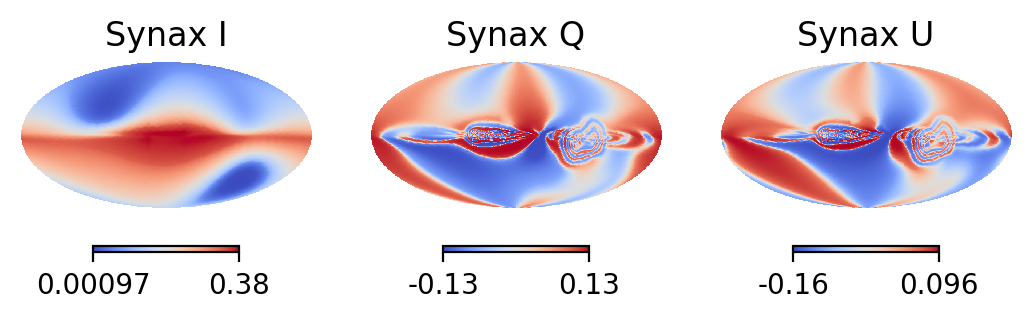

In [15]:
plt.figure(dpi=200)
np.random.seed(42)
plt.subplot(131)
hp.mollview(sync['I'],format='%.2g',norm='hist',cmap='coolwarm',hold=True,title='Synax I')

plt.subplot(132)
hp.mollview(sync['Q'],format='%.2g',norm='hist',cmap='coolwarm',hold=True,title='Synax Q')

plt.subplot(133)
hp.mollview(sync['U'],format='%.2g',norm='hist',cmap='coolwarm',hold=True,title='Synax U')



I hope follow these lines, you did generate the first simulation of your own with `synax`!

In [16]:
np.save('Sim_3lsa.npy',np.array([sync['Q'],sync['U']]))